Import everything needed

In [32]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

read file data 

In [34]:
file_path='amzn.csv'
df = pd.read_csv(file_path, parse_dates=['Date'])
print(df)

           Date     Open     High      Low    Close    Volume  OpenInt
0    1997-05-16     1.97     1.98     1.71     1.73  14700000        0
1    1997-05-19     1.76     1.77     1.62     1.71   6106800        0
2    1997-05-20     1.73     1.75     1.64     1.64   5467200        0
3    1997-05-21     1.64     1.65     1.38     1.43  18853200        0
4    1997-05-22     1.44     1.45     1.31     1.40  11776800        0
...         ...      ...      ...      ...      ...       ...      ...
5148 2017-11-06  1109.15  1125.41  1108.77  1120.66   3331738        0
5149 2017-11-07  1124.74  1130.60  1117.50  1123.17   2684443        0
5150 2017-11-08  1122.82  1135.54  1119.11  1132.88   2576010        0
5151 2017-11-09  1125.96  1129.62  1115.77  1129.13   3729978        0
5152 2017-11-10  1126.10  1131.75  1124.06  1125.35   2179181        0

[5153 rows x 7 columns]


Function to fill missing business days and set index to date

In [35]:
def reindex_and_fill(group):
    # Create full business day date range for that ticker
    group.set_index('Date',inplace=True)
    full_dates = pd.date_range(start=group.index.min(), end=group.index.max(), freq='B')
    # Reindex group to full dates (add missing rows)
    group = group.reindex(full_dates)
    # Interpolate missing numeric values linearly
    group = group.interpolate(method='linear', limit_direction='both')
    # Forward-fill any remaining missing values
    group = group.ffill()
    group['Date']=full_dates
    group.set_index(['Date'],inplace=True)
    return group


In [36]:
filled_df=reindex_and_fill(df)
print(filled_df)

               Open     High      Low    Close      Volume  OpenInt
Date                                                               
1997-05-16     1.97     1.98     1.71     1.73  14700000.0      0.0
1997-05-19     1.76     1.77     1.62     1.71   6106800.0      0.0
1997-05-20     1.73     1.75     1.64     1.64   5467200.0      0.0
1997-05-21     1.64     1.65     1.38     1.43  18853200.0      0.0
1997-05-22     1.44     1.45     1.31     1.40  11776800.0      0.0
...             ...      ...      ...      ...         ...      ...
2017-11-06  1109.15  1125.41  1108.77  1120.66   3331738.0      0.0
2017-11-07  1124.74  1130.60  1117.50  1123.17   2684443.0      0.0
2017-11-08  1122.82  1135.54  1119.11  1132.88   2576010.0      0.0
2017-11-09  1125.96  1129.62  1115.77  1129.13   3729978.0      0.0
2017-11-10  1126.10  1131.75  1124.06  1125.35   2179181.0      0.0

[5346 rows x 6 columns]


Adding all features i would be using later

In [37]:
# Daily return: percent change in 'Close' * 100
filled_df['Daily Return'] = (
    filled_df['Close'].pct_change() * 100
)

# 7-day moving average of 'Close'
filled_df['MA_7'] = (
    filled_df['Close'].shift(1).transform(lambda x: x.rolling(window=7, min_periods=0).mean())
)

# 30-day moving average of 'Close'
filled_df['MA_30'] = (
    filled_df['Close'].shift(1).transform(lambda x: x.rolling(window=30, min_periods=0).mean())
)

# 30-day rolling volatility of daily return
filled_df['Rolling Volatility (30d)'] = (
    filled_df['Close'].transform(lambda x: x.rolling(window=30, min_periods=0).std())
)

def calculate_rsi(data, period: int = 14):
    
    delta = data.shift(1).diff()

    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi


filled_df['RSI'] = calculate_rsi(filled_df['Close'], period=14)

print(filled_df)

               Open     High      Low    Close      Volume  OpenInt  \
Date                                                                  
1997-05-16     1.97     1.98     1.71     1.73  14700000.0      0.0   
1997-05-19     1.76     1.77     1.62     1.71   6106800.0      0.0   
1997-05-20     1.73     1.75     1.64     1.64   5467200.0      0.0   
1997-05-21     1.64     1.65     1.38     1.43  18853200.0      0.0   
1997-05-22     1.44     1.45     1.31     1.40  11776800.0      0.0   
...             ...      ...      ...      ...         ...      ...   
2017-11-06  1109.15  1125.41  1108.77  1120.66   3331738.0      0.0   
2017-11-07  1124.74  1130.60  1117.50  1123.17   2684443.0      0.0   
2017-11-08  1122.82  1135.54  1119.11  1132.88   2576010.0      0.0   
2017-11-09  1125.96  1129.62  1115.77  1129.13   3729978.0      0.0   
2017-11-10  1126.10  1131.75  1124.06  1125.35   2179181.0      0.0   

            Daily Return         MA_7        MA_30  Rolling Volatility (30d)

Create two numpy array one containing features and other target value. As we are using linear earregression we want some order. so, shuffle =False.

🧪 Test MSE: 103.2831


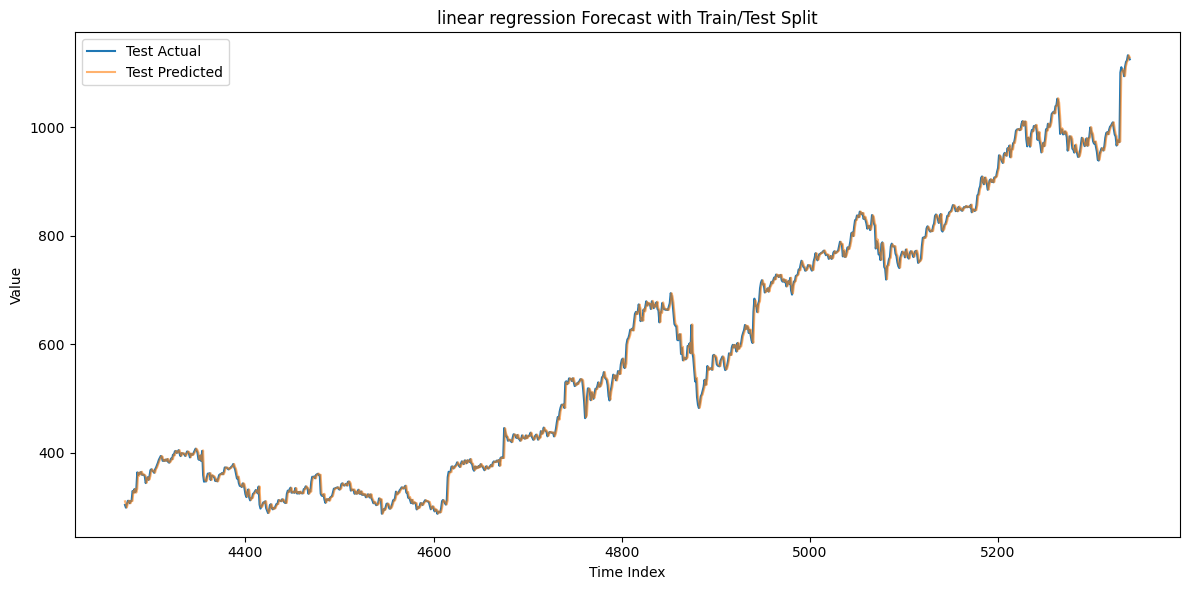

In [38]:
X = []
y = []

window_size = 5

for i in range(window_size, len(filled_df['Close'])):
    X.append(filled_df['Close'].iloc[i-window_size:i])  # past 5 days
    y.append(filled_df['Close'].iloc[i])                       # current day

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # Set shuffle=False to preserve time order
)

# 3. Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Predict on training data
y_pred = model.predict(X_test)

ms_test = mean_squared_error(y_test, y_pred)
print(f"🧪 Test MSE: {ms_test:.4f}")

plt.figure(figsize=(12, 6))

plt.plot(range(len(y_train), len(y_train)+len(y_test)), y_test, label='Test Actual')
plt.plot(range(len(y_train), len(y_train)+len(y_test)), y_pred, label='Test Predicted', alpha=0.6)
plt.title('linear regression Forecast with Train/Test Split')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

predicting using random forest. it only predict in range of min and max value it encountered in training data. so i set shuffle = true.

🧪 Test MSE: 43.8460


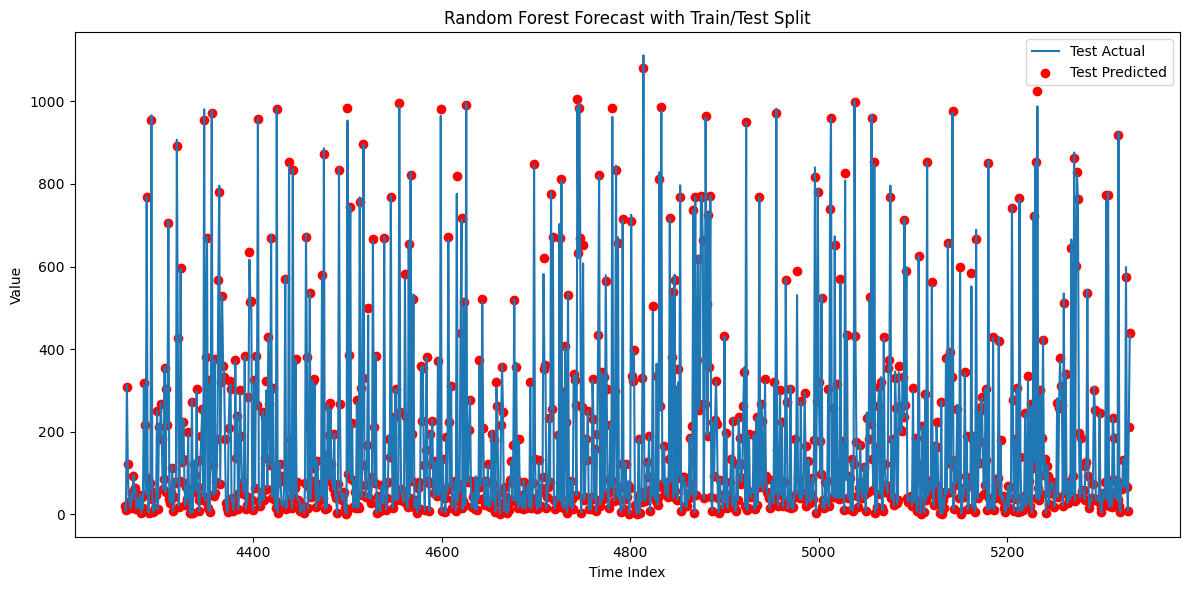

In [59]:
feat=filled_df[['MA_7','MA_30','RSI']][15:]

rX_train, rX_test, ry_train, ry_test = train_test_split(
    feat, filled_df['Close'][15:], test_size=0.2, random_state=40  # Set shuffle=False to preserve time order
)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(rX_train, ry_train)

df.sort_index(inplace=True)

# 5. Predict and evaluate
ry_test_pred = rf_model.predict(rX_test)

mse_test = mean_squared_error(ry_test, ry_test_pred)
print(f"🧪 Test MSE: {mse_test:.4f}")



plt.figure(figsize=(12, 6))
plt.plot(range(len(ry_train), len(ry_train)+len(ry_test)), ry_test, label='Test Actual')
plt.scatter(range(len(ry_train), len(ry_train)+len(ry_test)), ry_test_pred,color='red', label='Test Predicted', alpha=1)
plt.title('Random Forest Forecast with Train/Test Split')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

first, calculate order of differencing(by checking p value calculated by adfuller) which in this case turns out to be 1.
then we plot acp and pacf for q and p respectively (p=0 q=0).

Initial p-value: 1.0
Differencing 1 times, p-value: 5.662702788931061e-22

📊 Plotting ACF and PACF:


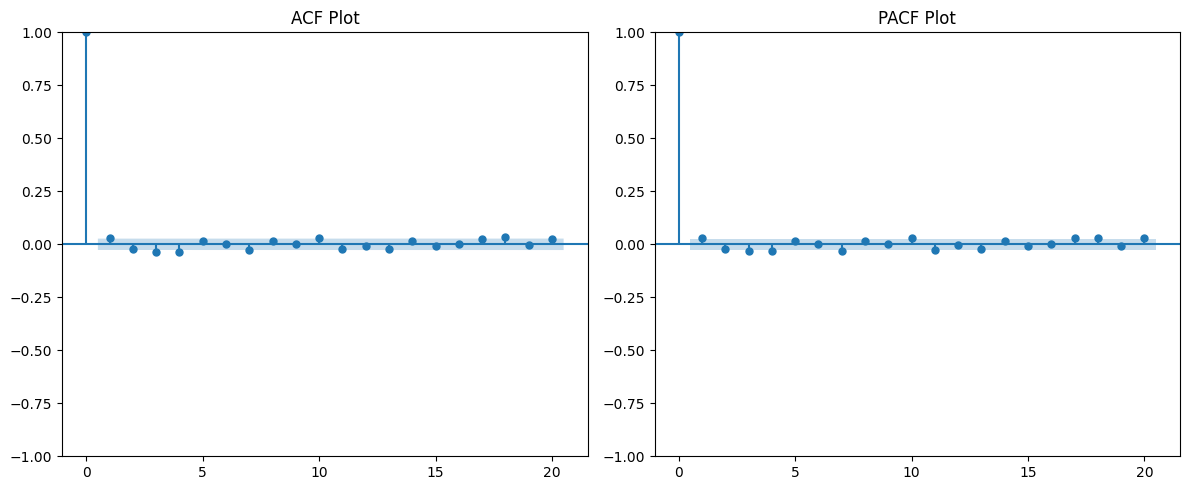

In [60]:
# 2. Function to check stationarity and apply differencing
def make_stationary(series, max_diff=5, significance_level=0.05):
    d = 0
    p_value = adfuller(series.dropna())[1]
    print(f"Initial p-value: {p_value}")

    while p_value > significance_level and d < max_diff:
        d += 1
        series = series.diff().dropna()
        p_value = adfuller(series)[1]
        print(f"Differencing {d} times, p-value: {p_value}")

    if p_value > significance_level:
        print("⚠️ Warning: Series may not be stationary even after max differencing.")

    return series, d


series=filled_df['Close']

# 3. Make series stationary
stationary_series, d = make_stationary(series)

# 4. Plot ACF and PACF to help decide p and q
print("\n📊 Plotting ACF and PACF:")
plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plot_acf(stationary_series, ax=plt.gca(), lags=20)
plt.title('ACF Plot')

plt.subplot(1, 2, 2)
plot_pacf(stationary_series, ax=plt.gca(), lags=20)
plt.title('PACF Plot')
plt.tight_layout()
plt.show()



Fitting and predicting

Enter value of p (from PACF plot):  0
Enter value of q (from ACF plot):  0


/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


📉 Mean Squared Error (MSE) = 128509.7716


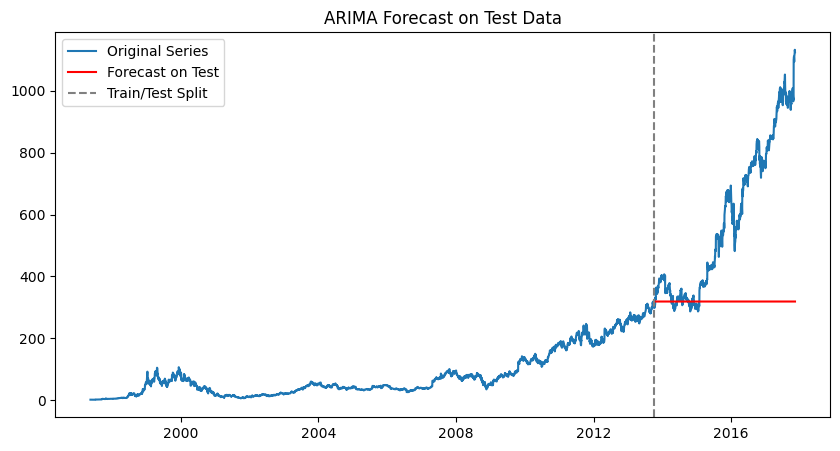

In [62]:
# 📌 Manually set p and q after observing the plots:
p = int(input("Enter value of p (from PACF plot): "))
q = int(input("Enter value of q (from ACF plot): "))

# --- Step 1: Train-Test Split (80-20) ---
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# --- Step 2: Fit ARIMA Model on Training Data ---

model = ARIMA(train, order=(p,d, q))
model_fit = model.fit()

# --- Step 3: Forecast on Test Data Length ---
forecast = model_fit.forecast(steps=len(test))


# --- Step 4: Calculate MSE ---
mse = mean_squared_error(test, forecast)
print(f"📉 Mean Squared Error (MSE) = {mse:.4f}")

# --- Step 5: Plot ---
plt.figure(figsize=(10, 5))
plt.plot(series, label='Original Series')
plt.plot(test.index, forecast, color='red', label='Forecast on Test')
plt.axvline(x=test.index[0], color='gray', linestyle='--', label='Train/Test Split')
plt.legend()
plt.title('ARIMA Forecast on Test Data')
plt.show()

as arima was the worst model in this case and even random forest is not good as it cannot predict for values higher that what it has encountered till now. linear regression was best for such plots.

I think random forests might actually work but we will have to continuously update data. Like once in a month as prices are not increasing that much in a month and then train randomly on new data (if possible, i dont know if it is possible to train on new data while retaining memory of past. i read about continuous learning once but not sure what it is) or on whole full data(old +new data)